## もくじ
1. テクニカル分析とは
1. テクニカル分析をする上で最低限知っておかなくてはいけない DataFrame の使い方

    1. データインポート　datetime, columns 処理も
    1. データアレンジ　欠損値など
    1. 関数とテクニック shift, pct_change(), bool値
    1. 描画
    1. 練習問題

1. テクニカル分析
    1. トレンド系
        1. 移動平均
        1. ボリンジャーバンド
        1. モメンタム
        1. HLバンド
    1. オシレーター系
        1. RSI
        1. MACD
        1. 株価カイリ率    
    1. 練習問題



## テクニカルとは

テクニカル分析というのは、

データから指標を作り、その指標と現在の値との関係を元に、将来を予測するもの
（と私は考えています）

指標とは、[Wikipedia](https://ja.wikipedia.org/wiki/%E6%8C%87%E6%A8%99)先生によると、**物事を判断したり評価したりするための目じるしとなるもの**です。（なるほど！)


## テクニカル分析をする上で最低限知っておかなくてはいけない DataFrame の使い方

テクニカル分析をする前に、知っておいてほうがよい pandas DataFrame の基本的な使い方を紹介します。これがすべてというわけではありませんが、ここでは必須知識ですので、覚えてください。

### データインポート

ここでは csv のデータのインポートと、その後の処理を行います。

まずは、[日経平均プロフィル-日経の指数公式サイト-　ダウンロードセンター](https://indexes.nikkei.co.jp/nkave/index?type=download)から，`日経平均株価＞日次データ`をダウロードしてください。そのファイルをDataFrame化します。



In [1]:

import pandas as pd 

# 適宜変更
fpath = '/tmp/nikkei_stock_average_daily_jp.csv'

df = pd.read_csv(fpath, 
                 encoding="shift-jis", # ここを外すとエンコードエラーが出る
                 index_col="データ日付", # index コラムを指定
                 )
# 最終行にいらないコメントが入っているのでそれを除去
df = df.iloc[:-1] 
# DataFrame を確認するために、tail()で最終行を確認。.head() でもOK
df.tail()



,終値,始値,高値,安値
データ日付,,,,
2018/11/27,21952.40,21967.98,22006.83,21816.05
2018/11/28,22177.02,22036.72,22216.98,22032.72
2018/11/29,22262.60,22360.98,22437.95,22241.17
2018/11/30,22351.06,22274.97,22362.20,22231.96
2018/12/03,22574.76,22629.39,22698.79,22550.29


#### ポイント＆解説

+ 慣習として DataFrame の変数は `df` とされる場合がおおい。
+ `encoding=` をはずとと`UnicodeDecodeError: 'utf-8' codec can't decode byte 0x83 in position 0: invalid start byte` 
+ ダウンロードしたファイルの最終行に、`本資料は日経の著作物であり、本資料の全部又は一部を・・・・`というコメントが入っているのでそれをスライスで削除


### データアレンジ

データの型を確認しましょう。パッと見て、数字や日次の様にみえて、実はただの文字列オブジェクトだったということはよく有ります。


In [2]:
# まずはデータ日付index. 
# dtype=が Datetimeindex でなくては行けません。
df.index

Index(['2015/01/05', '2015/01/06', '2015/01/07', '2015/01/08', '2015/01/09',
       '2015/01/13', '2015/01/14', '2015/01/15', '2015/01/16', '2015/01/19',
       ...
       '2018/11/19', '2018/11/20', '2018/11/21', '2018/11/22', '2018/11/26',
       '2018/11/27', '2018/11/28', '2018/11/29', '2018/11/30', '2018/12/03'],
      dtype='object', name='データ日付', length=963)

In [3]:
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-13', '2015-01-14', '2015-01-15',
               '2015-01-16', '2015-01-19',
               ...
               '2018-11-19', '2018-11-20', '2018-11-21', '2018-11-22',
               '2018-11-26', '2018-11-27', '2018-11-28', '2018-11-29',
               '2018-11-30', '2018-12-03'],
              dtype='datetime64[ns]', name='データ日付', length=963, freq=None)

In [4]:
# 次は価格。dtypeが数値型であればOK. 他のコラムも念の為確認しておきましょう。
df["終値"].head()


データ日付
2015-01-05    17408.71
2015-01-06    16883.19
2015-01-07    16885.33
2015-01-08    17167.10
2015-01-09    17197.73
Name: 終値, dtype: float64

コラム名を日本語から英語に変えたい人もいるかもしれません（私も英語派です）。その時はこのように辞書型を渡せばよいです。

In [5]:
df = df.rename(columns={"終値":"close", "始値":"open", "高値":"high", "安値":"low"})
df.head()

,close,open,high,low
データ日付,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22
2015-01-06,16883.19,17101.58,17111.36,16881.73
2015-01-07,16885.33,16808.26,16974.61,16808.26
2015-01-08,17167.10,17067.40,17243.71,17016.09
2015-01-09,17197.73,17318.74,17342.65,17129.53


In [6]:
# 一旦index化したコラム名は、このように変更します。
df.index.name = "datetime"
df.head()

,close,open,high,low
datetime,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22
2015-01-06,16883.19,17101.58,17111.36,16881.73
2015-01-07,16885.33,16808.26,16974.61,16808.26
2015-01-08,17167.10,17067.40,17243.71,17016.09
2015-01-09,17197.73,17318.74,17342.65,17129.53


### 関数とテクニック

DataFrameを使って分析する時にどうしても覚えなくてはいけない関数とテクニックを書きます。

#### shift 

データを上げさげする。


In [7]:
df.shift(1).head()

,close,open,high,low
datetime,,,,
2015-01-05,NaN,NaN,NaN,NaN
2015-01-06,17408.71,17325.68,17540.92,17219.22
2015-01-07,16883.19,17101.58,17111.36,16881.73
2015-01-08,16885.33,16808.26,16974.61,16808.26
2015-01-09,17167.10,17067.40,17243.71,17016.09


In [8]:
df_test = df.copy()
df_test["yesterday's close"] = df["close"].shift(1)
df_test.head()

,close,open,high,low,yesterday's close
datetime,,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22,NaN
2015-01-06,16883.19,17101.58,17111.36,16881.73,17408.71
2015-01-07,16885.33,16808.26,16974.61,16808.26,16883.19
2015-01-08,17167.10,17067.40,17243.71,17016.09,16885.33
2015-01-09,17197.73,17318.74,17342.65,17129.53,17167.10


In [9]:
df_test = df.copy()
df_test["tomorrow's open"] = df["open"].shift(-1)
df_test.head()

,close,open,high,low,tomorrow's open
datetime,,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22,17101.58
2015-01-06,16883.19,17101.58,17111.36,16881.73,16808.26
2015-01-07,16885.33,16808.26,16974.61,16808.26,17067.40
2015-01-08,17167.10,17067.40,17243.71,17016.09,17318.74
2015-01-09,17197.73,17318.74,17342.65,17129.53,16970.88


#### pct_change() 

n行前のデータからの変化率を出す。



In [10]:
df.pct_change().head()

,close,open,high,low
datetime,,,,
2015-01-05,NaN,NaN,NaN,NaN
2015-01-06,-0.030187,-0.012935,-0.024489,-0.019600
2015-01-07,0.000127,-0.017152,-0.007992,-0.004352
2015-01-08,0.016687,0.015417,0.015853,0.012365
2015-01-09,0.001784,0.014726,0.005738,0.006667


In [11]:
df_test = df.copy()
df_test["day return"] = df["close"].pct_change() # day return = 日次収益率
df_test.head()

,close,open,high,low,day return
datetime,,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22,NaN
2015-01-06,16883.19,17101.58,17111.36,16881.73,-0.030187
2015-01-07,16885.33,16808.26,16974.61,16808.26,0.000127
2015-01-08,17167.10,17067.40,17243.71,17016.09,0.016687
2015-01-09,17197.73,17318.74,17342.65,17129.53,0.001784


In [12]:
# shift を使って同じ計算ができるが、混乱しやすいので pct_change()がおすすめ。

(df / df.shift(1) - 1).head()

,close,open,high,low
datetime,,,,
2015-01-05,NaN,NaN,NaN,NaN
2015-01-06,-0.030187,-0.012935,-0.024489,-0.019600
2015-01-07,0.000127,-0.017152,-0.007992,-0.004352
2015-01-08,0.016687,0.015417,0.015853,0.012365
2015-01-09,0.001784,0.014726,0.005738,0.006667


#### ポイント：次の日の日次収益率を同じ行に入れて置きたい場合

注意：コラムに名前をつけるとき将来の数値だわかるようにしておくことが大切。


In [13]:
df_test = df.copy()
df_test["day return"] = df["close"].pct_change() # day return = 日次収益率
df_test["day return"] = df_test["day return"].shift(-1)
df_test.head()

,close,open,high,low,day return
datetime,,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22,-0.030187
2015-01-06,16883.19,17101.58,17111.36,16881.73,0.000127
2015-01-07,16885.33,16808.26,16974.61,16808.26,0.016687
2015-01-08,17167.10,17067.40,17243.71,17016.09,0.001784
2015-01-09,17197.73,17318.74,17342.65,17129.53,-0.006397


#### bool 値を使う

bool値を使うと simulation をする時に便利です。

例えば、始値から終値が上昇した場合、その日の大引けで買って、次の日の寄りで売るというsimulationを書いてみます。

（一口メモ：大引けから寄りの間だけポジションを持つ事を、「オーバーナイトでポジションを持つ」といいます。）


In [14]:
df_test = df.copy()
df_test["intraday return"] = df_test["close"] / df_test["open"] - 1 # intraday return = 日中収益率
df_test["is intraday return positive"] = df_test["intraday return"] > 0 
df_test.head()

,close,open,high,low,intraday return,is intraday return positive
datetime,,,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22,0.004792,True
2015-01-06,16883.19,17101.58,17111.36,16881.73,-0.012770,False
2015-01-07,16885.33,16808.26,16974.61,16808.26,0.004585,True
2015-01-08,17167.10,17067.40,17243.71,17016.09,0.005842,True
2015-01-09,17197.73,17318.74,17342.65,17129.53,-0.006987,False


In [15]:
# オーバーナイトの収益を計算
df_test["overnight return"] = df_test["open"].shift(-1) / df["close"] - 1
df_test.head()

,close,open,high,low,intraday return,is intraday return positive,overnight return
datetime,,,,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22,0.004792,True,-0.017642
2015-01-06,16883.19,17101.58,17111.36,16881.73,-0.012770,False,-0.004438
2015-01-07,16885.33,16808.26,16974.61,16808.26,0.004585,True,0.010783
2015-01-08,17167.10,17067.40,17243.71,17016.09,0.005842,True,0.008833
2015-01-09,17197.73,17318.74,17342.65,17129.53,-0.006987,False,-0.013191


`2015-01-05`で、日中収益率は0.47％で正です。そこで終値で株を買うことにします。

`overnight return` には終値から次の日の始値の変化率（＝オーバーナイトの収益率）が入っています。気をつけなくてはいけないのは、ここに入っている数値は将来の数字だと言うことです。

例えば `2015-01-05` 時点で、`overnight return` である `-0.017642` は明日にならないとわからない数値です。

ここで、`is intraday return positive` は正負、つまり、1もしくは0のどちらかですので、

`is intraday return positive * overnight return`  を計算することで、`is intraday return positive`が正の時だけの数値を得ることが出来ます。


In [16]:
df_test["results"] = df_test["is intraday return positive"] * df_test["overnight return"]
df_test.head(10)

,close,open,high,low,intraday return,is intraday return positive,overnight return,results
datetime,,,,,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22,0.004792,True,-0.017642,-0.017642
2015-01-06,16883.19,17101.58,17111.36,16881.73,-0.012770,False,-0.004438,-0.000000
2015-01-07,16885.33,16808.26,16974.61,16808.26,0.004585,True,0.010783,0.010783
2015-01-08,17167.10,17067.40,17243.71,17016.09,0.005842,True,0.008833,0.008833
2015-01-09,17197.73,17318.74,17342.65,17129.53,-0.006987,False,-0.013191,-0.000000
2015-01-13,17087.71,16970.88,17087.71,16828.27,0.006884,True,-0.007367,-0.007367
2015-01-14,16795.96,16961.82,17036.72,16770.56,-0.009778,False,0.004584,0.000000
2015-01-15,17108.70,16872.95,17141.98,16856.22,0.013972,True,-0.017286,-0.017286
2015-01-16,16864.16,16812.96,16864.34,16592.57,0.003045,True,0.008101,0.008101


### 描画

結果は視覚的に見たほうが楽しいですよね。

上記で行った結果を描画してみましょう。



In [17]:
# resultsをプロット
df_test["results"].plot()

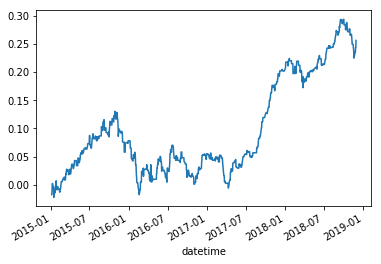

In [18]:
# 毎日の結果を足し合わせていってプロット
df_test["results"].cumsum().plot()

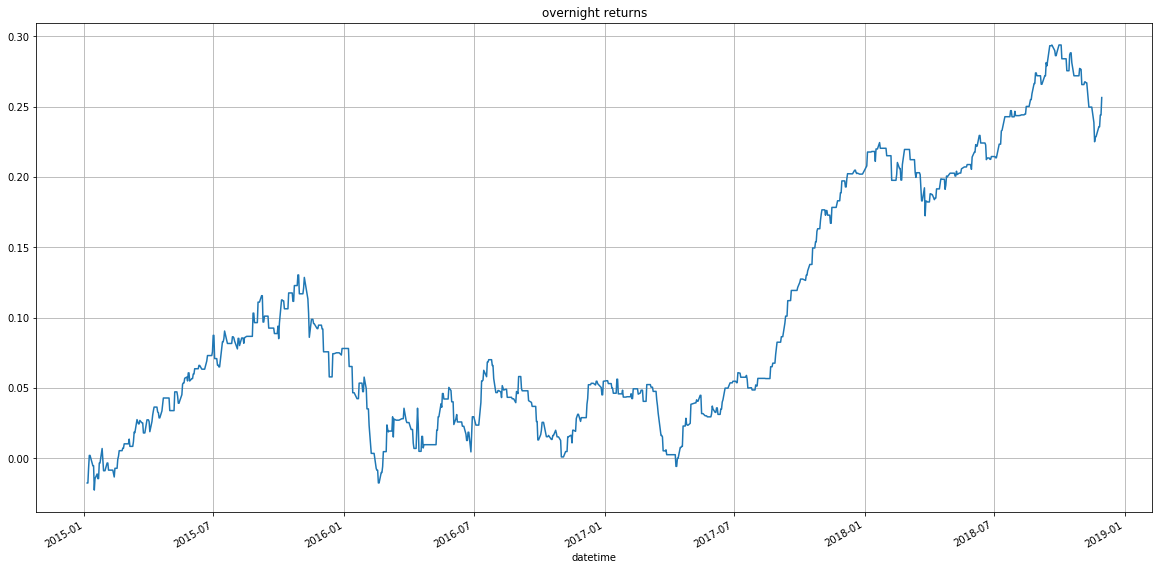

In [19]:
# 色々なオプションを入れる。
df_test["results"].cumsum().plot(grid=True, # 罫線
                                 figsize = (20,10), # (横, 縦)
                                 title="overnight returns"
                                )

### 練習問題1

1. [https://finance.yahoo.com/quote/SPY/history?p=SPY](https://finance.yahoo.com/quote/SPY/history?p=SPY) からデータダウンロードする。
2. ファイルをDataFrame化する。
3. オーバーナイトの収益をプロットする
4. 日中のHighとLowの差が2％以上だったら、Closeで買って、次の日のCloseで売る。その収益をプロットする。


## テクニカル分析

世の中にはたくさんのテクニカル分析が有ります。投資家に人気がある分析指標を使って simulation をしてみましょう。


1. トレンド系
    1. 移動平均
    1. ボリンジャーバンド
    1. モメンタム
    1. HLバンド
1. オシレーター系
    1. RSI
    1. MACD
    1. 株価カイリ率   
        


### 移動平均

移動平均とは、時系列データにおいて、ある一定区間ごとの平均値を区間をずらしながら求めたものです。毎日のデータを見るよりも、株価の方向（流れ、大局、）をより見やすくする指標と言えます。

DataFrameのメソッドである `rolling` を使うと簡単に求められます。

+ [pandas.DataFrame.rolling](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html)
+ rolling(window, min_periods=None, center=False, win_type=None, on=None, axis=0, closed=None)
+ `window`: 行数を指定。これが区間になる。
+ 返り値は `rolling` オブジェクト。

In [20]:
df_test = df.copy()

# 5日移動平均
n = 5
df_test.rolling(n)

Rolling [window=5,center=False,axis=0]

In [21]:
# この rolling オブジェクトが持つメソッドを使って、ほしい計算結果を得る。
df_test.rolling(n).mean().head(10)

,close,open,high,low
datetime,,,,
2015-01-05,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN
2015-01-09,17108.412,17124.332,17242.650,17010.966
2015-01-13,17044.212,17053.372,17152.008,16932.776
2015-01-14,17026.766,17025.420,17137.080,16910.542
2015-01-15,17071.440,17038.358,17170.554,16920.134
2015-01-16,17010.852,16987.470,17094.680,16835.430


プロットして観察します。

株価と移動平均を重ねてプロットすると、なにか気がつくかもしれません。

すこし複雑な図を描く時は `matplotlib.pyplot` を使うと便利です。詳しくは、[PythonユーザのためのJupyter[実践]入門](https://www.amazon.co.jp/dp/4774192236)を買って勉強してください。

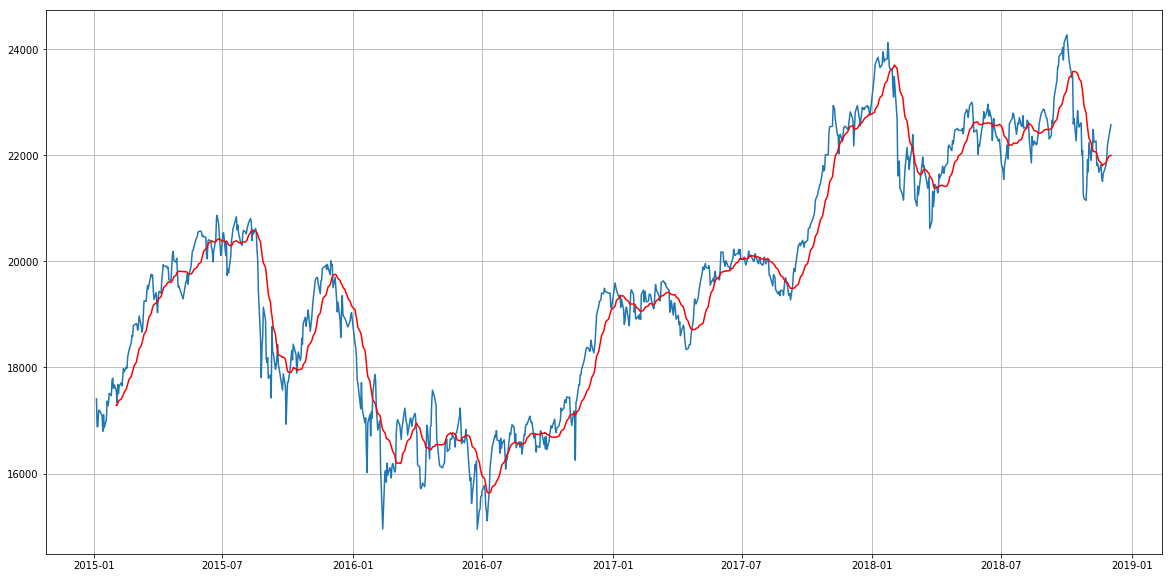

In [22]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)

ax1.plot(df_test["close"])
ax1.plot(df_test["close"].rolling(window=20).mean(), c='r')
ax1.grid()


さて、この描画から、どんなことが言えそうでしょうか？観察して考えてみましょう。

1. 過去n日と比べて今日の終値が大きく外れていれば、「平均の方にもどるんじゃない？」と予想して逆張り
1. 終値が移動平均より上にある間は買い持ちして、下にある間は売り持ちする。（順張り）

などが考えられます。1をやってみましょう。

まずは、移動平均と終値がどのくらい違いがあるのか見てみましょう。


In [23]:
df_test = df.copy()

n = 20

# ma : Moving Average の略。移動平均を表す時によく使われる。
df_test["ma"] = df_test["close"].rolling(window=n).mean() 
# close と ma しか使わないのでそれだけのDataFrameにする。
df_test = df_test[["close", "ma"]]

df_test["diff"] = df_test["close"] / df_test["ma"] - 1
df_test.head(30)


,close,ma,diff
datetime,,,
2015-01-05,17408.71,NaN,NaN
2015-01-06,16883.19,NaN,NaN
2015-01-07,16885.33,NaN,NaN
2015-01-08,17167.10,NaN,NaN
2015-01-09,17197.73,NaN,NaN
2015-01-13,17087.71,NaN,NaN
2015-01-14,16795.96,NaN,NaN
2015-01-15,17108.70,NaN,NaN
2015-01-16,16864.16,NaN,NaN


DataFrameのデータを簡単な統計値で確認したい時 `describe()` が便利です。

columns 毎に、個数、平均値、偏差、最大値、最小値、パーセンタイルを出してくれます。

In [25]:
df_test.describe()

,close,ma,diff
count,964.000000,945.000000,945.000000
mean,19641.066504,19642.268723,0.002528
std,2212.264659,2169.909670,0.027475
min,14952.020000,15628.831000,-0.120078
25%,17768.060000,17933.336000,-0.011017
50%,19617.095000,19603.302000,0.005317
75%,21664.337500,21693.677500,0.020869
max,24270.620000,23700.905000,0.065013


ここから察するに、`25%` タイルで `-1.1%` ずれているということなので、

close価格が maより-1.1％以下にある場合、ロングポジションを持つことにしてみましょう。



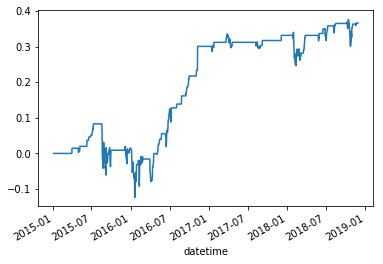

In [32]:
df_test["diff < -0.011"] = df_test["diff"] < -0.011
df_test["day return"] = df_test["close"].pct_change().shift(-1)
df_test["long position result"] = df_test["diff < -0.011"] * df_test["day return"]
df_test["long position result"].cumsum().plot()

悪くないですね。

**練習問題**

では、`75%`タイルで `2.08％` ずれているので、

close価格が maより2.08％以上にある場合、ショートポジションを持つことにしてみましょう。

ショートポジション（売り持ち）なので、`df_test["day return"]` の計算をどのようにすればよいか注意してください

### ボリンジャーバンド

ボリンジャーバンドも、個人投資家に大変人気のある指標です。ボリバンとも呼ばれています。ボリンジャーとか、ボリバンとか呼ばれています。

移動平均だけでなく、その期間にどのくらい値がバラついたかも算出してバンドを形成し指標化したものです。

この図でいえば、<font color=red>BB_中心線（21）</font>というのが21日移動平均線、<font color=blue>BB_1σ</font>という線が、過去21日の値動きのバラツキの1σ区間です。

![](https://www.jibunbank.co.jp/products/foreign_deposit/chart/help/bollinger_band/img/img_01.png)
[ボリンジャーバンド | チャートの見方 | 為替レート＆チャート | じぶん銀行](https://www.jibunbank.co.jp/products/foreign_deposit/chart/help/bollinger_band/)より

そんな事言われてもわからんと思いますので、実際算出してみましょう。

ボリバンを出すのに便利なライブラリ `talib` を使います。

[mrjbq7/ta-lib: Python wrapper for TA-Lib (http://ta-lib.org/).](https://github.com/mrjbq7/ta-lib)


In [26]:
%matplotlib inline
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
#import talib as ta

# warning 非表示
import warnings
warnings.filterwarnings('ignore')

# https://kabuoji3.com/stock/

stock0 = "/tmp/7201_2018.csv"
stock1 = "/tmp/6758_2018.csv"
stock2 = "/tmp/3436_2018.csv"
stock3 = "/tmp/8306_2018.csv"

df_stock0 = pd.read_csv(stock0, skiprows=[0], encoding='shift-jis', index_col="日付", parse_dates=True)
df_stock1 = pd.read_csv(stock1, skiprows=[0], encoding='shift-jis', index_col="日付", parse_dates=True)
df_stock2 = pd.read_csv(stock2, skiprows=[0], encoding='shift-jis', index_col="日付", parse_dates=True)
df_stock3 = pd.read_csv(stock3, skiprows=[0], encoding='shift-jis', index_col="日付", parse_dates=True)

df_stock_list = [df_stock0, df_stock1, df_stock2, df_stock3,]
stock_name_list = ["NISSAN", "SONY", "SUMCO", "MUFG",]

all_data = pd.concat(df_stock_list, 
                    keys=stock_name_list,
                    names=['Ticker', 'Date'])

df_close = all_data["終値調整値"].reset_index().pivot('Date', 'Ticker', '終値調整値')


In [3]:
df_close.head()

Ticker,MUFG,NISSAN,SONY,SUMCO
Date,,,,
2018-01-04,847.1,1134.0,5279.0,2996.0
2018-01-05,866.8,1149.0,5464.0,2989.0
2018-01-09,863.4,1156.5,5612.0,3100.0
2018-01-10,876.8,1156.5,5591.0,3070.0
2018-01-11,881.9,1157.5,5584.0,2967.0


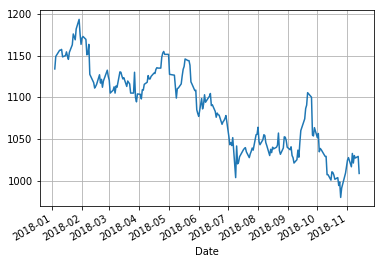

In [7]:
## 株価の動きをプロットしてみる。
df_close["NISSAN"].plot(grid=True, )


In [19]:
# 日次収益率
df_close["NISSAN"].pct_change().head()

Date
2018-01-04         NaN
2018-01-05    0.013228
2018-01-09    0.006527
2018-01-10    0.000000
2018-01-11    0.000865
Name: NISSAN, dtype: float64

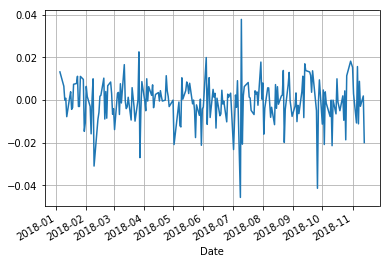

In [20]:
# 日次収益率をプロット
df_close["NISSAN"].pct_change().plot(grid=True, )


In [18]:
## shift を使い慣れる
df_close.head()

Ticker,MUFG,NISSAN,SONY,SUMCO
Date,,,,
2018-01-04,847.1,1134.0,5279.0,2996.0
2018-01-05,866.8,1149.0,5464.0,2989.0
2018-01-09,863.4,1156.5,5612.0,3100.0
2018-01-10,876.8,1156.5,5591.0,3070.0
2018-01-11,881.9,1157.5,5584.0,2967.0


In [15]:
df_close.shift(1).head()


Ticker,MUFG,NISSAN,SONY,SUMCO
Date,,,,
2018-01-04,NaN,NaN,NaN,NaN
2018-01-05,847.1,1134.0,5279.0,2996.0
2018-01-09,866.8,1149.0,5464.0,2989.0
2018-01-10,863.4,1156.5,5612.0,3100.0
2018-01-11,876.8,1156.5,5591.0,3070.0


In [78]:
df_close.shift(-1).head()

Ticker,MUFG,NISSAN,SONY,SUMCO
Date,,,,
2018-01-04,866.8,1149.0,5464.0,2989.0
2018-01-05,863.4,1156.5,5612.0,3100.0
2018-01-09,876.8,1156.5,5591.0,3070.0
2018-01-10,881.9,1157.5,5584.0,2967.0
2018-01-11,873.1,1148.5,5525.0,2951.0


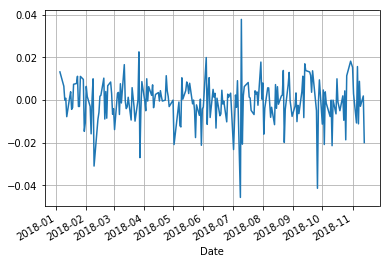

In [79]:
# もう一度日次収益率をプロット
df_close["NISSAN"].pct_change().plot(grid=True, )

In [29]:
# -2％以上動いたら次の日は反動で戻っている様に見えるので、それで最初のストラテジーを組む
df_nissan = df_close[["NISSAN"]]
df_nissan["day return"] = df_nissan.pct_change()
df_nissan["buy flag"] = df_nissan["day return"] < -0.02
df_nissan.head()

Ticker,NISSAN,day return,buy flag
Date,,,
2018-01-04,1134.0,NaN,False
2018-01-05,1149.0,0.013228,False
2018-01-09,1156.5,0.006527,False
2018-01-10,1156.5,0.000000,False
2018-01-11,1157.5,0.000865,False


In [32]:
df_nissan["future return"] = df_nissan["NISSAN"].shift(-1) / df_nissan["NISSAN"] -1
df_nissan.head()


Ticker,NISSAN,day return,buy flag,future return
Date,,,,
2018-01-04,1134.0,NaN,False,0.013228
2018-01-05,1149.0,0.013228,False,0.006527
2018-01-09,1156.5,0.006527,False,0.000000
2018-01-10,1156.5,0.000000,False,0.000865
2018-01-11,1157.5,0.000865,False,-0.007775


In [35]:
df_nissan["strategy result"] = df_nissan["buy flag"] * df_nissan["future return"]



In [38]:
df_nissan["strategy result"].sum()

0.014798772912829827

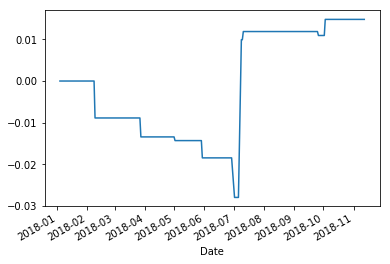

In [39]:
df_nissan["strategy result"].cumsum().plot()

In [12]:
## 移動平均
## 当日から過去N日間の平均を毎日取得する。N日間を window と呼ぶ

# pandas.DataFrame.rolling　を使う
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html

# window=5 を渡して５日毎の束を持つインスタンスを作る
df_close.rolling(window=5)

Rolling [window=5,center=False,axis=0]

In [19]:
## 各Windowで平均を出す
df_close.rolling(window=5).mean().head(10)

Ticker,MUFG,NISSAN,SONY,SUMCO
Date,,,,
2018-01-04,NaN,NaN,NaN,NaN
2018-01-05,NaN,NaN,NaN,NaN
2018-01-09,NaN,NaN,NaN,NaN
2018-01-10,NaN,NaN,NaN,NaN
2018-01-11,867.20,1150.7,5506.0,3024.4
2018-01-12,872.40,1153.6,5555.2,3015.4
2018-01-15,876.80,1153.8,5555.0,3007.2
2018-01-16,881.98,1153.4,5527.4,2995.2
2018-01-17,882.80,1152.0,5501.0,3002.2


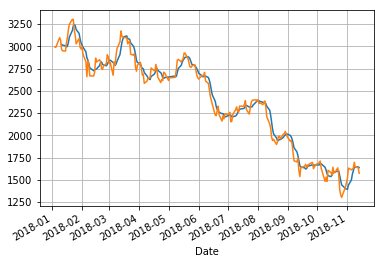

In [82]:
## 移動平均と終値をプロットして観察
df_close["SUMCO"].rolling(window=5).mean().plot()
df_close["SUMCO"].plot(grid=True)


In [42]:
## 移動平均は過去ｎ日間の平均をつかった指標。
## 例えば
## 1.過去n日と比べて今日の終値が大きく外れていれば、「平均の方にもどるんじゃない？」と予想して逆張りしたり、
## 2.終値が移動平均より上にある間は買い持ちして下にある間は売り持ちする
## といったことに使ったりしているようです

## 1 をシュミレーションしてみましょう。
## 過去n日と比べて今日の終値が大きく外れている、とは、
## 何％はずれているかを決めなくては行けません。

## たとえば５日移動平均だを見ると、NISSANは±0.01以上差ができた場合は戻るのではないか？
## と疑いを持つとします。
## プロットしてみましょう

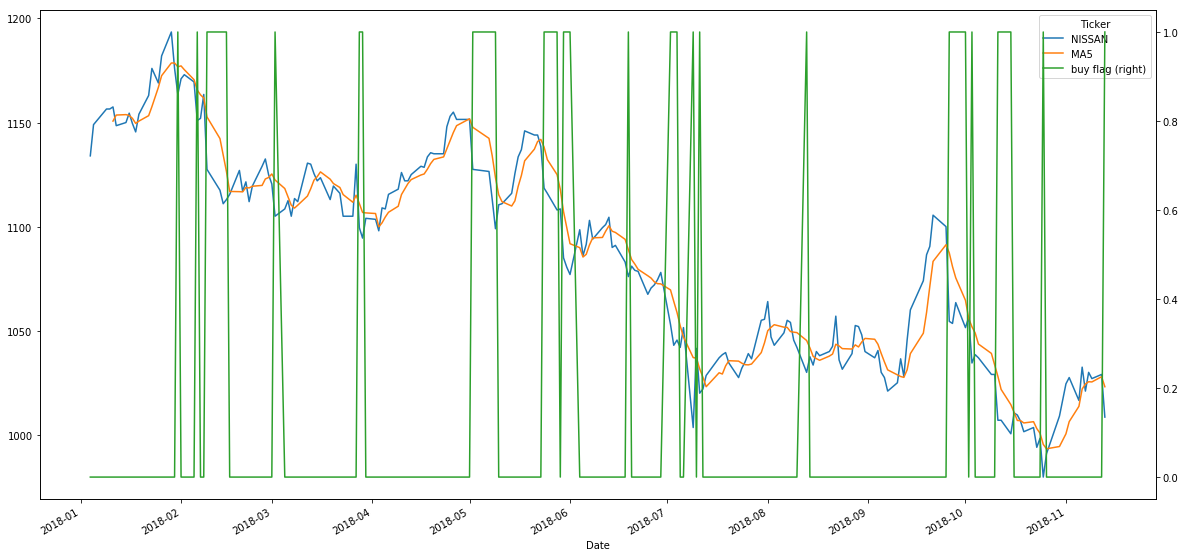

In [91]:
df = df_close[["NISSAN"]]
df["MA5"] =  df["NISSAN"].rolling(window=5).mean()
df["buy flag"] = ((df["NISSAN"] / df["MA5"] - 1) < -0.01) * 1
#df["sell flag"] = ((df["NISSAN"] / df["MA5"] - 1) > 0.01) * 1
df.plot(secondary_y=["buy flag","sell flag"], figsize=(20,10))


In [95]:
## では、0.01以上になったら売り持ちし、−0.01以下になったら買い持ち、
## それぞれ10日持ったらポジションをクローズするシュミレーションをしてみましょう

def simulation1(df_close, symbol_name="NISSAN", window=5, thred=0.01, hold=10):
    """
    df_close: 終値のDataFrame
    symbol_name: 銘柄名
    window: 移動平均を計算する期間
    thred: 乖離の距離
    hold: 銘柄保有期間
    """
    
    df_ma = df_close.rolling(window=window).mean()
    df_diff = df_close / df_ma - 1

    df = pd.DataFrame({
        "CLOSE":df_close[symbol_name], 
         "MA":df_ma[symbol_name],
         "DIFF":df_diff[symbol_name]})

    df["long flag"] = df["DIFF"] < thred * -1
    df["short flag"] = df["DIFF"] > thred

    ## 注意：ここは同じ row に未来のReturnが入っている状態
    df["future_return"] = df["CLOSE"].shift(-1) / df["CLOSE"]   - 1
    
    longs = df[df["long flag"]].index
    shorts = df[df["short flag"]].index
    
    for date in longs:
        df.loc[date:].head(hold)["long flag"]=True
    for date in shorts:
        df.loc[date:].head(hold)["short flag"]=True
        
    simulation = df["future_return"] * df["long flag"] + df["future_return"] * df["short flag"]*-1 
    return simulation 


In [98]:
result = simulation1(df_close, )
result.head(20)

Date
2018-01-04    0.000000
2018-01-05    0.000000
2018-01-09    0.000000
2018-01-10    0.000000
2018-01-11    0.000000
2018-01-12    0.000000
2018-01-15    0.000000
2018-01-16    0.000000
2018-01-17    0.000000
2018-01-18    0.000000
2018-01-19    0.000000
2018-01-22    0.000000
2018-01-23    0.002976
2018-01-24    0.002985
2018-01-25   -0.011121
2018-01-26   -0.009729
2018-01-29    0.014663
2018-01-30    0.010629
2018-01-31    0.000000
2018-02-01    0.000000
dtype: float64

In [100]:
result.cumsum().head(20)
# 悪くはない感じ。

Date
2018-01-04    0.000000
2018-01-05    0.000000
2018-01-09    0.000000
2018-01-10    0.000000
2018-01-11    0.000000
2018-01-12    0.000000
2018-01-15    0.000000
2018-01-16    0.000000
2018-01-17    0.000000
2018-01-18    0.000000
2018-01-19    0.000000
2018-01-22    0.000000
2018-01-23    0.002976
2018-01-24    0.005961
2018-01-25   -0.005159
2018-01-26   -0.014889
2018-01-29   -0.000226
2018-01-30    0.010403
2018-01-31    0.010403
2018-02-01    0.010403
dtype: float64

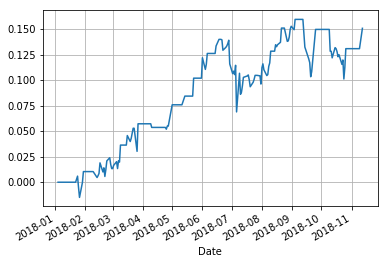

In [101]:
# 悪くないかも
result.cumsum().plot(grid=True)

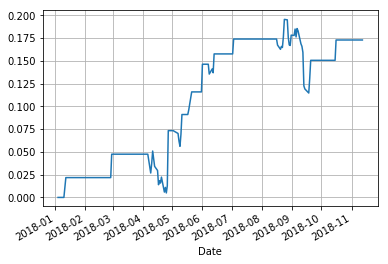

In [72]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
result = simulation2(df_close,window=20)
ax1.plot(result.cumsum())

ax2 = ax1.twinx()
ax2.plot(df_close["NISSAN"], c='g')
ax2.plot(df_close["NISSAN"].rolling(window=20).mean(), c='r')# SONYなら
simulation1(df_close, symbol_name="SONY").plot(grid=True)

In [67]:
## 条件を変えて色々試してみましょう.新しい銘柄をダウンロードしてもいいし、他の年でも試したりしてもいいですね。

## 2.終値が移動平均より上にある間は買い持ちして下にある間は売り持ちする
## プロットして確認してみる

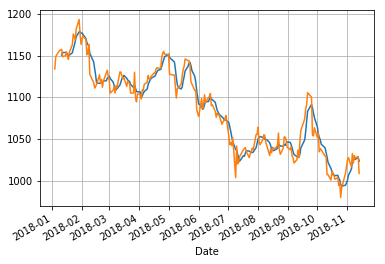

In [92]:
df_close.rolling(window=5).mean()["NISSAN"].plot()
df_close["NISSAN"].plot(grid=True)

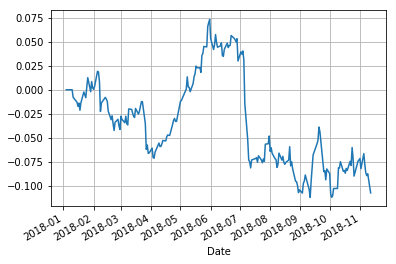

In [102]:
def simulation2(df_close, symbol_name="NISSAN", window=5):
    """
    df_close: 終値
    symbol_name: 銘柄名
    window: 保有期間
    """
    s_ma = df_close[symbol_name].rolling(window=window).mean()
    s_long = df_close[symbol_name] > s_ma 
    s_short = df_close[symbol_name] < s_ma
    
    s_future_return = df_close[symbol_name].shift(-1) / df_close[symbol_name] - 1 
    s_simulation = s_future_return * s_long + s_future_return * s_short * -1 
    
    return s_simulation

simulation2(df_close).cumsum().plot(grid=True)
    

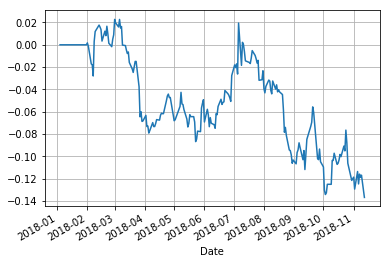

In [103]:
simulation2(df_close,window=20).cumsum().plot(grid=True)

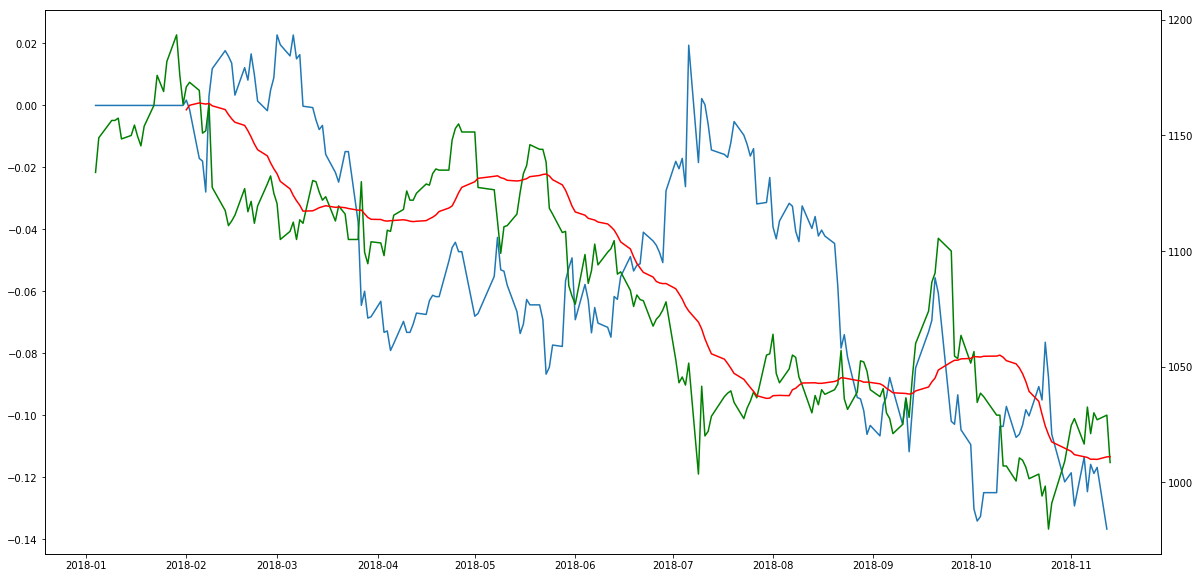

In [110]:
# どういう時に負けているか、確認
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
result = simulation2(df_close,window=20)
ax1.plot(result.cumsum())

ax2 = ax1.twinx()
ax2.plot(df_close["NISSAN"], c='g')
ax2.plot(df_close["NISSAN"].rolling(window=20).mean(), c='r')

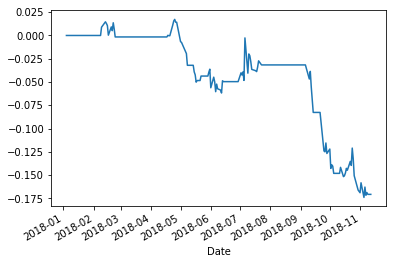

In [125]:
## 終値と移動平均が”十分”に離れている時は儲かっていてそうではない時に損してそう。
## simulation2 を改造してみましょう


## HL バンド

def get_adj_prices(all_data, symbol_name):
    df_adj_close = all_data["終値調整値"].reset_index().pivot('Date', 'Ticker', '終値調整値')
    df_open = all_data["始値"].reset_index().pivot('Date', 'Ticker', '始値')
    df_high = all_data["高値"].reset_index().pivot('Date', 'Ticker', '高値')
    df_low = all_data["安値"].reset_index().pivot('Date', 'Ticker', '安値')
    df_close = all_data["終値"].reset_index().pivot('Date', 'Ticker', '終値')
    
    df_adj = df_adj_close / df_close
    df_adj_open = df_open * df_adj
    df_adj_high = df_high * df_adj
    df_adj_low = df_low * df_adj
    df = pd.concat([df_adj_open[symbol_name], df_adj_high[symbol_name], df_adj_low[symbol_name], df_adj_close[symbol_name]], axis=1)
    df.columns=['open', 'high', 'low', 'close']
    return df

get_adj_prices(all_data, "NISSAN").head()

## では、20日間のHLバンドで、
## それぞれ10日持ったらポジションをクローズするシュミレーションをしてみましょう

def simulation_HL(all_data, symbol_name="NISSAN", window=20,hold=10):  
    df = get_adj_prices(all_data, symbol_name)
    df['high_band'] = df['high'].rolling(window=window).max()
    df['low_band'] = df['low'].rolling(window=window).min()
    df["long_flag"] = df['close'] > df['high_band'].shift(1)
    df["short_flag"] = df['close'] < df['low_band'].shift(1)
    
    ## 注意：ここは同じ row に未来のReturnが入っている状態
    df["future_return"] = df["close"].shift(-1) / df["close"]   - 1
    #
    longs = df[df["long_flag"]].index
    shorts = df[df["short_flag"]].index
    
    for date in longs:
        df.loc[date:].head(hold)["long_flag"]=True
    for date in shorts:
        df.loc[date:].head(hold)["short_flag"]=True
    df['conflict'] = df['long_flag']*df['short_flag']
    df['long_flag'] = df['long_flag']*(df['conflict'] == False)
    df['short_flag'] = df['short_flag']*(df['conflict'] == False)
       
    return df["future_return"] * df["long_flag"] + df["future_return"] * df["short_flag"]*-1


simulation_HL(all_data,).cumsum().plot()


In [122]:
# memo

import os
import glob

def csv_to_pan(directory= '/tmp/stocks/*csv', ):

    files = glob.glob(directory)
    d = dict()
    for f in files:
        code = (os.path.split(f)[1].replace(".csv",""))
        d[code] = pd.read_csv(f, index_col="日付", parse_dates=True)

    pan = pd.Panel(d)
    return pan 

pan = csv_to_pan()


<class 'pandas.core.panel.Panel'>
Dimensions: 0 (items) x 0 (major_axis) x 0 (minor_axis)
Items axis: None
Major_axis axis: None
Minor_axis axis: None